In [2]:
using Logging
Logging.disable_logging(LogLevel(3))

using LinearAlgebra
using SparseArrays
using KrylovKit
using Plots
using Colors
using IterTools
using Polynomials, SpecialPolynomials
using IterativeSolvers
using LinearMaps

@show Threads.nthreads();

Threads.nthreads() = 4



(process:14448): GLib-GIO-WARNING **: 16:46:49.104: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_19.0.3.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


In [156]:

function assembly(T,J,N,N²)
    Λ = spzeros(N²,N²);
    @views for i in 1:N
        Λ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] .= T[:,:]
    end
    
    @views for i in 1:N-1
        Λ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] .= J[:,:] # remplissage blocs etradiag supérieurs
        Λ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] .= J[:,:] # remplissage blocs extradiag inférieurs
    end
    return Λ
end

function hamiltonian_2D(δr, δr², δR, δR², N, N², V, m, M)
    # BLOC EXTRA-DIAGONAL 
    J = -1/(2*M*δR²)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*δr²)+1/(M*δR²))*ones(Float64,N);  # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*δr²)*ones(Float64,N-1);     # vecteur de la sur- et sous-diagonale remplies de 1
    T = - SymTridiagonal(diag, extra_diag);    # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = assembly(T,J,N,N²)
    V = Diagonal(reshape(V,N²)); # a priori inutile de convertir en sparse avant

    H = Λ+V;
    H, Λ, V # opérateurs (matrices de taille N²×N²)
end


function hamiltonian_1D(Δd², N, V, m)
    Λ = -1/(Δd²*2*m)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
    V = Diagonal(V); # V_fun.(LinRange(r_min,r_max,N)) pour créer l'argument
    H = Λ + V; 
    H, Λ, V
end



function hamiltonian_2D_rescaled(δr, δr², δu, δu², N, N², V, m, ϵ², K)
    # BLOC EXTRA-DIAGONAL 
    J = -K*ϵ²/(2*δu²)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*δr²)+K*ϵ²/δu²)*ones(Float64,N); # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*δr²)*ones(Float64,N-1);     # vecteur de la sur- et sous-diagonale remplies de 1
    T = - SymTridiagonal(diag, extra_diag);    # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = assembly(T,J,N,N²);
    V = Diagonal(reshape(V,N²)); # a priori inutile de convertir en sparse avant

    H = Λ + V;
    H, Λ, V # opérateurs (matrices de taille N²×N²)
end

x = variable(Polynomial{Rational{Int}})
H = [SpecialPolynomials.basis(Hermite, i)(x) for i in 0:3] # /!\ au décalage d'incice
ϕ1Dk = (n,x,m,k) -> (k*m)^(.125)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1]((k*m)^(.25)*x)*exp(-sqrt(k*m)/2*x^2);
ϕ1Du = (n,u,m,k) -> (k*m)^(.125)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1](u)*exp(-1/2*u^2); # u tel que r = ϵu


function get_parameters(r_min, r_max, R_min, R_max, N)
    δr = (r_max-r_min)/(N-1);
    δR = (R_max-R_min)/(N-1);
    δr² = δr*δr;
    δR² = δR*δR;
    N² = N^2;

    # CONSTRUCTION DE LA MESHGRID
    rs = Vector(r_min:δr:r_max); # sur l'axe donne r ↦ r en direction coordonnée électron
    Rs = Vector(R_min:δR:R_max); # sur l'axe donne R ↦ R en direction coordonnée distance noyau-noyau
    rg = ones(N)' .* rs;         # sur la grille donne   (r,R) ↦ r
    Rg = Rs' .* ones(N);         # sur la grille donne   (r,R) ↦ R
    V = zeros(N,N);              # sur la grille donnera (r,R) ↦ V(r,R) après évaluation ci-dessous

    # CONSTRUCTION DU POTENTIEL ORIGINAL ET DU HAMILTONIEN SUR GRILLE paramétré en R
    V = @. V_nucl_el(rg, Rg) + V_nucl_nucl(Rg); # potentiel d'interaction sur la grille tous phénomènes compris
    Ĥ, Λ, V̂ = hamiltonian_2D(δr, δr², δR, δR², N, N², V, m, M);

    # STRUCTURE DU LAPLACIEN 1D
    LS = SymTridiagonal(-2*ones(Float64,N), ones(Float64,N-1)); 

    # LAPLACIENS SUR AXES
    Λr = -1/(δr²*2*m)*LS;  # laplacien sur l'axe r
    ΛR = -1/(δR²*2*M)*LS;  # laplacien sur l'axe R
    return δr, δR, δr², δR², N², rs, Rs, rg, Rg, V, Ĥ, Λ, V̂, LS, Λr, ΛR
end


function get_lowest_surface_energy(Λr, δR, R_min, rs, N)
    # à changer pour faire une dichotomie ou une biblithèque d'optimisation
    # RECHERCHE DU R₀  minimisant l'énergie de l'état fondamental
    lE₀ = zeros(N);
    Base.Threads.@threads for j in 1:N
        Vx = sparse(Diagonal(Vector(V_nucl_el.(rs,R_min+j*δR)))) # potentiel en x à R=jδR fixé (i.e. à distance noyau-noyau fixé)
        vals, ~, infos = KrylovKit.eigsolve(Λr+Vx, N, 1, :SR, krylovdim=kdim);
        @assert infos.converged > 0;
        lE₀[j]     = infos.converged>=1 ? vals[1] + V_nucl_nucl(R_min + j*δR)  : NaN;
        # on récupère l'énergie  propre du niveau fondamental sur la tranche à R fixé
    end  


    # CALCUL DU R₀ ET DES RAIDEURS
    E₀_at_R₀, ind_R₀ = findmin(lE₀);       # trouver l'énergie de surface minimale
    R₀               = ind_R₀*δR + R_min;  # définir le paramètre nucléaire minimisant l'énergie de surface
    K = 1/(δR)^2 * dot([−1/560 8/315 −1/5 8/5 −205/72 8/5 −1/5 8/315 −1/560], view(lE₀, ind_R₀-4:ind_R₀+4));  # on calcule la dérivée seconde  à l'ordre 8 par rapport à y de E₀ en R₀
    # constante de raideur sur l'axe (Oy) pour le hamiltonien non perturbé
    return lE₀, E₀_at_R₀, ind_R₀, R₀, K
end

function get_rescaling(N)
    # NOUVEAUX PARAMETRES SUR AXE avec rescaling
    u_min = -3.;     # à fixer de manière à ce que les conditions de Dirichlet soient satisfaites aux bords          
    u_max =  3.;     # idem
    δu = (u_max-u_min)/(N-1);
    δu² = δu^2;
    us = Vector(u_min:δu:u_max);  # sur l'axe donne u ↦ u   
    ug = us' .* ones(N);          # sur la grille donne (r,u) ↦ u
    return u_min, u_max, δu, δu², us, ug
end


function get_parameters_rescaled(u_min, u_max, δu, δu², us, ug, K, M, N, N², LS, V, Rs, rs, rg, Rg, δR, δr, δR², δr², Λ, Λr, ΛR, ind_R₀, R₀)
    ϵ = 1/sqrt(sqrt(K*M)); # paramètre de redimensionnement
    ϵ² = ϵ^2;

    Λu = -K*ϵ²/δu²*LS;            # laplacien sur l'axe (Ou)

    # FONCTIONS POTENTIELS HBO NON PERTURBÉS SUR AXES SÉPARÉS  
    V₀rs  = V[:,ind_R₀];          # cf formule 3.19 deuxième ligne du rapport sans la constante .- E₀_at_R₀
    V₀Rs  = .5*K*(Rs.-R₀).^2;     # cf formule 3.19 première ligne du rapport sans la constante .+ E₀_at_R₀
    V₀us  = .5*K*(ϵ*us).^2        # cf formule 3.23 première ligne du rapport sans la constante .+ E₀_at_R₀

    # OPÉRATEURS POTENTIELS HBO NON PERTURBÉS SUR AXES SÉPARÉS 
    V̂⁰rs  = Diagonal(V₀rs);
    V̂⁰Rs  = Diagonal(V₀rs);
    V̂⁰us  = Diagonal(V₀us);

    # HAMILTONIENS NON PERTURBÉS SUR AXES SÉPARÉS
    Ĥ⁰r  = Λr + V̂⁰rs;
    Ĥ⁰R  = ΛR + V̂⁰Rs;

    # OPÉRATEURS RESCALED SUR GRILLE
    V_res = @. V_nucl_el(rg, R₀.+ϵ*ug) + V_nucl_nucl(R₀.+ϵ*ug); # (r,u) ↦ V(r,u) 

    # FONCTION POTENTIEL HBO NON PERTURBÉ SUR GRILLE
    # formule 3.19: somme des deux premières lignes en potentiel:
    # que deux car seulement deux paramétrages (R et u)
    V₀Rg = @. V[:,ind_R₀]*ones(N)'  + .5*K*(Rg.-R₀).^2; # (r,R) ↦ V(r,R₀) + 1/2*(∂²E₀/∂R²)(R₀)(R-R₀)²
    V₀ug = @. V_nucl_el(rg, R₀) + V_nucl_nucl(R₀)  + .5*K*ϵ²*ug.^2;   # (r,u) ↦ V(r,u₀) + Kϵ²/2*(∂²E₀/∂u²)(u₀)(u-u₀)²

    # OPÉRATEUR POTENTIEL NON PERTURBÉ SUR GRILLE
    V̂⁰Rg = Diagonal(reshape(V₀Rg, N²));
    V̂⁰ug = Diagonal(reshape(V₀ug, N²));

    # CONSTRUCTION DU POTENTIEL ET DU HAMILTONIEN NON PERTURBÉS HBO SUR GRILLE
    Ĥ⁰ = Λ + V̂⁰Rg; # hamiltonien HBO non perturbé paramétré en R
    𝔥₀,~,~  = hamiltonian_2D_rescaled(δr, δr², δu, δu², N, N², V₀ug, m, ϵ², K); # hamiltonien HBO non perturbé paramétré en u

    # pour + tard: symétriser un peu la construction de ces variables

    # OPÉRATEUR RESCALÉ ORIGINAL SUR GRILLE
    𝔥,~,~  = hamiltonian_2D_rescaled(δr, δr², δu, δu², N, N², V_res, m, ϵ², K) # 𝔥 : Ψ(r,u) ∈ L²(ℝ^N^2) ↦ -1/2m × ∂²/∂r² -1/2M × ∂²/∂u² + V(r,u) le hamiltonien original complet

    # FONCTION PERTURBATION Vp (développement de Taylor de la perturbation)
    # ordre 1 en espace: (∂V/∂R)(r,R₀)×(R-R₀)
    ∂R_of_V_at_rR₀   = 1/δR*  V[:,ind_R₀-4:ind_R₀+4] * [1/280 −4/105 1/5 −4/5 0. 4/5 −1/5 4/105 −1/280]';       # vecteur, donne r      ↦ ∂V/∂R(r,R₀)
    V₁               = ∂R_of_V_at_rR₀*ones(N)' .* (Rg.-R₀);                                                     # matrice, donne (r, R) ↦ ∂V/∂R(r,R₀)

    # ordre 2 en espace: 1/2×[(∂²V/∂R²)(r,R₀) - d²E₀/dR²(R₀)](R-R₀)² 
    ∂²RR_of_V_at_rR₀ = 1/δR²* V[:,ind_R₀-4:ind_R₀+4] * [−1/560 8/315 −1/5 8/5 −205/72 8/5 −1/5 8/315 −1/560]';  # vecteur, donne r      ↦ ∂²V/∂R²(r,R₀)
    V₂               = .5*(∂²RR_of_V_at_rR₀*ones(N)' .- K) .* (Rg.-R₀).^2;                                      # matrice, donne (r, R) ↦ ∂V/∂R(r,R₀)

    # perturbation totale ordre 1 + ordre 2 en espace (troncature à automatiser éventuellement à tout ordre)
    Vp = V₁ + V₂;

    # OPÉRATEUR PERTURBATION paramétré en R
    Ŵ  = Diagonal(reshape(Vp, N²)); # ψ∈L²(ℝ^N²) ↦ Vp×ψ

    # OPÉRATEURS HAMILTONIENS NON PERTURBÉS RESCALÉS SUR AXES SÉPARÉS
    𝔥u =   K*ϵ²*(-1/2/δu²*LS + 1/2*Diagonal(us.^2));  # 𝔥u : ψ(u) ∈ L²(ℝ^N) ↦ 1/2 × Kϵ²(-∂²/∂u² + u²)ψ pour la solution-produit tensoriel
    # 𝔥u = Λu + V̂⁰us;
    𝔥r = Λr + V̂⁰rs;                                   # 𝔥r : ψ(r) ∈ L²(ℝ^N) ↦ 1/2 ×    (-∂²/∂r² + R²)ψ pour la solution-produit tensoriel

    𝔴  =  @.  V_nucl_el(rg, R₀.+ϵ*ug) + V_nucl_nucl(R₀)  - V_nucl_el(rg, R₀) - V_nucl_nucl(R₀+ϵ*ug) +  1/2*ϵ²*K*ug.^2 # (r,u) ↦ V(r,R₀) - V(r,R₀+ϵu) + Kϵ²/2*u²  (éq. 3.23 du rapport)
    𝔴₁ = ϵ*∂R_of_V_at_rR₀.*ug;
    𝔴₂ = .5*ϵ^2*(∂²RR_of_V_at_rR₀*ones(N)' .- K) .*ug.^2;
    Vp_res = 𝔴₁ + 𝔴₂;
        
    Ŵu = Diagonal(reshape(Vp_res,N²)); # opérateur correspondant à la perturbation paramétrée en u
    return ϵ, ϵ², Λu, V₀rs, V₀rs, V₀us, Ĥ⁰r, Ĥ⁰R, V_res, V₀Rg, V₀ug, V̂⁰Rg, V̂⁰ug, Ĥ⁰, V₁, V₂, Vp, Vp_res, Ŵ, 𝔥, 𝔥u, 𝔥r, 𝔴, Ŵu, 𝔥₀
end

get_parameters_rescaled (generic function with 2 methods)

In [157]:
function decompose_hamiltonian_rescaled(r_min, r_max, R_min, R_max, N, V_nucl_el, V_nucl_nucl, m, lM, kdim, Qmax)

    δr, δR, δr², δR², N², rs, Rs, rg, Rg, V, Ĥ, Λ, V̂, LS, Λr, ΛR = get_parameters(r_min, r_max, R_min, R_max, N);
    
    l = length(lM);
    l_Ψ_pert = zeros(N²,l);
    l_Ψ_true = zeros(N²,l);
    l_Ψ_HBO  = zeros(N²,l);
    l_E_true = zeros(l);
    l_E_pert = zeros(l);

    u_min, u_max, δu, δu², us, ug = get_rescaling(N);

    ############# COMMENCER LA BOUCLE ICI POUR LA MASSE (ce qui précède ne change pas si M change) #############
    ind_M = 1;
    for M in lM
        ### CALCUL DE L'ÉNERGIE DE SURFACE ###
        lE₀, E₀_at_R₀, ind_R₀, R₀, K = get_lowest_surface_energy(Λr, δR, R_min, rs, N);
        println("ok1"); flush(stdout)
        
        ### CALCUL DES OPÉRATEURS ###
        ϵ, ϵ², Λu, V₀rs, V₀rs, V₀us, Ĥ⁰r, Ĥ⁰R, V_res, V₀Rg, V₀ug, V̂⁰Rg, V̂⁰ug, Ĥ⁰, V₁, V₂, Vp, Vp_res, Ŵ, 𝔥, 𝔥u, 𝔥r, 𝔴, Ŵu, 𝔥₀ = get_parameters_rescaled(u_min, u_max, δu, δu², us, ug, K, M, N, N², LS, V, Rs, rs, rg, Rg, δR, δr, δR², δr², Λ, Λr, ΛR, ind_R₀, R₀);
        println("ok2"); flush(stdout)

        ### CALCUL DE LA SOLUTION-PRODUIT HARMONIC-BORN-OPPENHEIMER ###
        lE⁰x, lϕ⁰x, infos_x = KrylovKit.eigsolve(Ĥ⁰r, N, 1, :SR, krylovdim=10); # ou bien avec 𝔥r, car Ĥ⁰r = 𝔥r
        @assert infos_x.converged ≥ 1;
        
        lE⁰u, lϕ⁰u, infos_u = KrylovKit.eigsolve(𝔥u, N, 1, :SR, krylovdim=10);
        @assert infos_u.converged ≥ 1;
        println("ok3"); flush(stdout)

        ΨHBO = lϕ⁰x[1] * lϕ⁰u[1]'; # normé car les deux le sont déjà en sortant de Krylov
        ΨHBO = reshape(ΨHBO, N²)
        EHBO = lE⁰x[1] + lE⁰u[1];
        densité_HBO = N^2/(u_max-u_min)/(r_max-r_min);
        println("ok4"); flush(stdout)

        l_Ψ_pert[:,ind_M] = ΨHBO;
        l_Ψ_HBO[:,ind_M]  = ΨHBO;
        l_E_pert[ind_M]   = EHBO;
        println("ok5"); flush(stdout)

        ### CALCUL DE LA SOLUTION 2D POUR RÉFÉRENCE DU HAMILTONIEN D'INTÉRÊT PARAMÉTRÉ EN u ###
        lE, lϕ, info_2d = KrylovKit.eigsolve(𝔥, N², 1, :SR, krylovdim=40); # KrylovKit.eigsolve plus rapide que Arpack.eigs globalement
        @assert info_2d.converged ≥ 1;
        println("ok6"); flush(stdout)

        l_Ψ_true[:,ind_M] = lϕ[1];
        l_E_true[ind_M] = lE[1];
        ### CALCUL DES PERTURBATIONS ###
        Ψ₀ = copy(ΨHBO);
        W =  copy(Ŵu); # W: sparse
        H₀ = copy(𝔥₀); # sparse
        E₀ = EHBO;
        println("ok7"); flush(stdout)
        # Qmax   = 3;

        proj = x -> dot(Ψ₀,x)*Ψ₀; # on gagne ~1 prdre de grandeur en temps en utilisant dot au lieu du produit matriciel Ψ₀*(Ψ₀'*x)
        Π_ort  = LinearMap(x -> x - proj(x), N²); # ne pas assembler
        Π_par  = LinearMap(x -> proj(x), N²);

        P_ort  = LinearMap(x -> Π_ort(H₀*Π_ort(x)-E₀*Π_ort(x)), N²); # Π⟂(H₀-E₀)Π⟂
        P_par  = LinearMap(x -> Π_par(H₀*Π_par(x)-E₀*Π_par(x)), N²); # Π∥(H₀-E₀)Π∥

        llΨ    = zeros(Float64, N², Qmax); # création liste des termes d'énergie   en fonction de l'ordre q
        llE    = zeros(Float64, Qmax);      # création liste des termes de vecteurs en fonction de l'ordre q

        Wl     = LinearMap(x -> W*x, N²);
        b      = -Π_ort(W*Ψ₀); # -Π⟂WΨ₀ dans 3.63
        println("ok8"); flush(stdout)

        ### GRADIENTS CONJUGUÉS ordre 1 et sauvegarde ###
        llΨ[:,1] = cg(P_ort, b);
        llE[1]    = Ψ₀'*Wl(Ψ₀); # terme d'énergie à l'ordre 1
        
        l_Ψ_pert[:,ind_M] += ϵ*llΨ[:,1];
        l_E_pert[ind_M]   += ϵ*llE[1];

        println("ok9"); flush(stdout)

        ### GRADIENTS CONJUGUÉS ordres 2+ et sauvegarde ###
        WlmE₁ = LinearMap(x -> W*x-llE[1]*x, N²);


        R_ort  = -Π_ort*WlmE₁;
        R_par  = -Π_par*WlmE₁;

        acc_b   = zeros(N²);
        acc_ort = zeros(N²);
        acc_par = zeros(N²);

        println("ok10"); flush(stdout)

        for q ∈ 2:Qmax
            # calcul énergie ordre q
            llE[q] = Ψ₀'*WlmE₁(llΨ[:,q-1]); # premier terme de 3.65

            for i ∈ 1:(q-2)
                llE[q] = llE[q] - llE[q-i]* Ψ₀'*llΨ[:,i]; # somme du second terme dans 3.65
            end

            # calcul état ordre q
            fill!(acc_b, 0.);
            @views acc_ort[:] = llE[q]*Ψ₀; # dernier terme de la somme de LHS dans 3.66 à i=0
            @views acc_par[:] = llE[q]*Ψ₀; # dernier terme de la somme de LHS dans 3.67 à i=0

            for i ∈ 1:(q-2)
                @. acc_ort[:] = acc_ort + llE[q-i]*llΨ[:,i] # autres termes de la somme dans LHS de 3.66
                @. acc_par[:] = acc_par + llE[q-i]*llΨ[:,i] # autres termes de la somme dans LHS de 3.67
            end
            acc_ort[:] = -Π_ort(WlmE₁(llΨ[:,q-1])) + Π_ort(acc_ort); # LHS de 3.66 complet
            acc_par[:] = -Π_ort(WlmE₁(llΨ[:,q-1])) + Π_ort(acc_par); # LHS de 3.66 complet
            

            acc_ort[:] = cg(P_ort, acc_ort);
            acc_par[:] = cg(P_par, acc_par)
            llΨ[:,q] = Array(acc_ort + acc_ort);
            l_Ψ_pert[:,ind_M] += ϵ^q*llΨ[:,q];
            l_E_pert[ind_M]  += ϵ^q*llE[q];
        end
        println("ok11"); flush(stdout)        

        ind_M += 1;
    end
    return l_E_pert, l_E_true, l_Ψ_pert, l_Ψ_true, l_Ψ_HBO, # états
           δr, δR, δr², δR², N², rs, Rs, rg, Rg, V, Ĥ, Λ, V̂, LS, Λr, ΛR, # paramètres
           u_min, u_max, δu, δu², us, ug, # rescaling
           ϵ, ϵ², Λu, V₀rs, V₀rs, V₀us, Ĥ⁰r, Ĥ⁰R, V_res, V₀Rg, V₀ug, V̂⁰Rg, V̂⁰ug, Ĥ⁰, V₁, V₂, Vp, Ŵ, 𝔥, 𝔥u, 𝔥r, 𝔴, Ŵu, 𝔥₀ # opérateurs
end

decompose_hamiltonian_rescaled (generic function with 1 method)

In [158]:
Qmax = 1;me = 1; mp = 500;
M=(2*mp^3+mp^2*me)/(2*mp*(me+mp));
m=(2*mp^2*me)/(mp*(2*mp+me)); 
r_min=-5.; r_max=5.; R_min=0.0; R_max=3.5; N=70; ω=1.; kdim=30; # augmenter la dimension Krylov quand N est grand: pour N=200, prendre kdim=50
β=1.5; η=.5; V0=1.5; σ=1.;


function V_nucl_el(r,R)
     return -V0*( exp(-(r-R/2)^2/2/σ^2) + exp(-(r+R/2)^2/2/σ^2) ) # potentiels interaction électron avec les 2 noyaux
end

function V_nucl_nucl(R)
     return + β/sqrt(η^2+R^2) # potentiel interaction des 2 noyaux entre eux
end

# on appelle la fonction avec les différents epsilon (différentes masses pour M)
lM = [500, 1000];
l_E_pert, l_E_true, l_Ψ_pert, l_Ψ_true, l_Ψ_HBO, δr, δR, δr², δR², N², rs, Rs, rg, Rg, V, Ĥ, Λ, V̂, LS, Λr, ΛR, u_min, u_max, δu, δu², us, ug, ϵ, ϵ², Λu, V₀rs, V₀rs, V₀us, Ĥ⁰r, Ĥ⁰R, V_res, V₀Rg, V₀ug, V̂⁰Rg, V̂⁰ug, Ĥ⁰, V₁, V₂, Vp, Ŵ, 𝔥, 𝔥u, 𝔥r, 𝔴, Ŵu, 𝔥₀  = decompose_hamiltonian_rescaled(r_min, r_max, R_min, R_max, N, V_nucl_el, V_nucl_nucl, m, lM, kdim, Qmax);

# on appelle également les fonctions une à une pour mettre à jour les paramètres des boucles
@time δr, δR, δr², δR², N², rs, Rs, rg, Rg, V, Ĥ, Λ, V̂, LS, Λr, ΛR = get_parameters(r_min, r_max, R_min, R_max, N)
@time lE₀, E₀_at_R₀, ind_R₀, R₀, K = get_lowest_surface_energy(Λr, δR, R_min, rs, N);
@time u_min, u_max, δu, δu², us, ug = get_rescaling(N);
@time ϵ, ϵ², Λu, V₀rs, V₀rs, V₀us, Ĥ⁰r, Ĥ⁰R, V_res, V₀Rg, V₀ug, V̂⁰Rg, V̂⁰ug, Ĥ⁰, V₁, V₂, Vp, Vp_res, Ŵ, 𝔥, 𝔥u, 𝔥r, 𝔴, Ŵu, 𝔥₀ = get_parameters_rescaled(u_min, u_max, δu, δu², us, ug, K, M, N, N², LS, V, Rs, rs, rg, Rg, δR, δr, δR², δr², Λ, Λr, ΛR, ind_R₀, R₀);

ok1


ok2


ok3


ok4


ok5


ok6


ok7


ok8


ok9


ok10


ok11


ok1


ok2


ok3


ok4


ok5


ok6


ok7


ok8


ok9


ok10


ok11


  0.067442 seconds (83.46 k allocations: 3.659 MiB, 33.11% gc time)
  0.015605 seconds (111.30 k allocations: 18.979 MiB)
  0.000044 seconds (25 allocations: 40.328 KiB)
  0.624328 seconds (1.51 M allocations: 66.150 MiB, 86.96% compilation time)


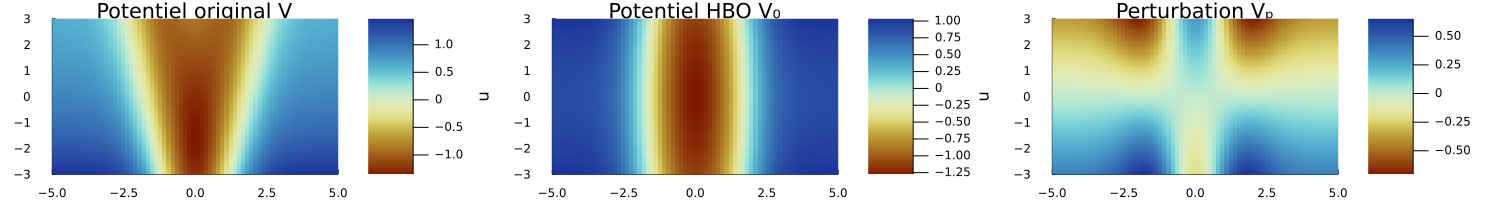

In [161]:
plot_V   = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), V_res', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Potentiel original V", grid=true, aspect_ratio=:auto ) 
plot_V₀  = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), V₀ug', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Potentiel HBO V₀", aspect_ratio=:auto )
plot_Vp  = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), Vp_res', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Perturbation Vₚ", aspect_ratio=:auto )
plot(plot_V, plot_V₀, plot_Vp, layout = (1, 3), legend = false, size=(1500,200), down_margin = 10Plots.mm)

  0.001246 seconds (1.46 k allocations: 363.141 KiB)
info.converged = 3


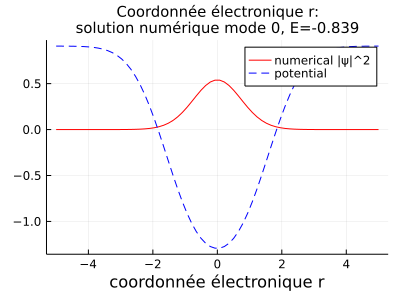

In [162]:
@time lE, lϕ, info = KrylovKit.eigsolve(𝔥r, N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 

nr = 0; densité_r = N/(r_max-r_min);
plot(rs,
    [densité_r*abs.(lϕ[nr+1]).^2, V₀rs],
    grid=true,
    w=[1 1],
    color = ["red" "blue"],
    linestyle=[:solid :dash],
    xlabel="coordonnée électronique r",
    label=["numerical |ψ|^2" "potential"],
    title = "Coordonnée électronique r:\nsolution numérique mode $nr, E=$(round(lE[nr+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

  0.001251 seconds (1.34 k allocations: 335.375 KiB)
info.converged = 3


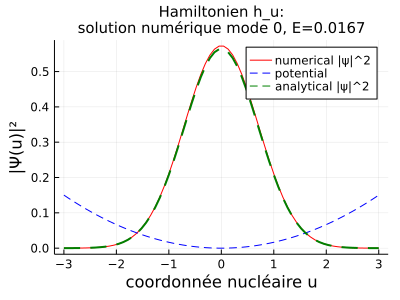

In [163]:
@time lE⁰u, lϕ⁰u, info = KrylovKit.eigsolve(𝔥u, N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 

nu = 0; densité_u = N/(u_max-u_min);
sol_analytique_u = [sqrt(ϵ)*ϕ1Du(nu,u,M,K) for u in us];
plot(us,
    [densité_u*abs.(lϕ⁰u[nu+1]).^2, V₀us, sol_analytique_u.^2],
    grid=true,
    w=[1 1 2],
    color = ["red" "blue" "green"],
    linestyle=[:solid :dash :dash],
    xlabel="coordonnée nucléaire u",ylabel="|Ψ(u)|²",
    label=["numerical |ψ|^2" "potential" "analytical |ψ|^2"],
    title = "Hamiltonien h_u:\nsolution numérique mode $nu, E=$(round(lE⁰u[nu+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

  0.063461 seconds (4.71 k allocations: 35.525 MiB)


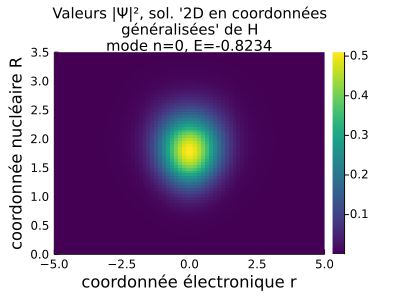

In [165]:
@time lE, lϕ, info = KrylovKit.eigsolve(𝔥, N*N, 2, :SR, krylovdim=40);
@assert info.converged ≥ 1;
mode_numérique = 0; 
densité = N^2/(R_max-R_min)/(r_max-r_min);
ϕH = lϕ[mode_numérique+1];
ϕH_p = densité*Matrix(transpose(reshape(ϕH.^2,N,N)));
heatmap(rs, Rs, ϕH_p,
    xlims = (r_min,r_max),
    ylims = (R_min,R_max),
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire R",
    title = "Valeurs |Ψ|², sol. '2D en coordonnées\ngénéralisées' de H\nmode n=$mode_numérique, E=$(round(lE[mode_numérique+1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    color=:viridis,
    right_margin = 7Plots.mm,
    up_margin = 3Plots.mm)

### Paramètres généraux du problème avec un potentiel

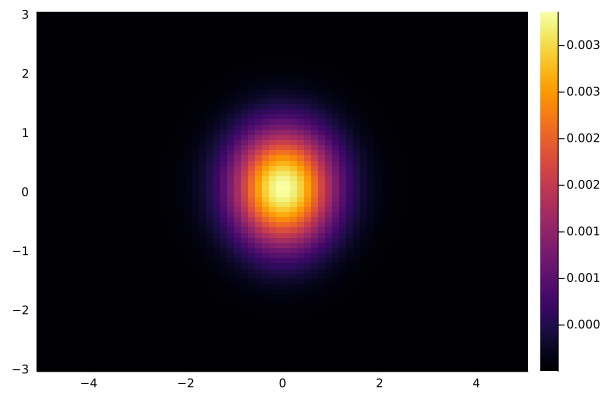

In [166]:
heatmap(rs, us, reshape(l_Ψ_pert[:,2],N,N)'.^2)

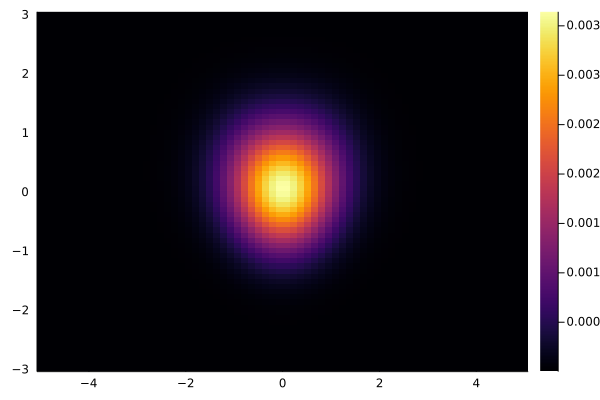

In [167]:
heatmap(rs, us, reshape(l_Ψ_true[:,1],N,N)'.^2)

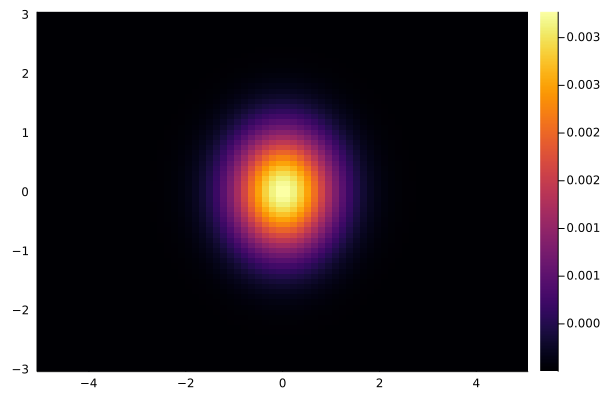

In [168]:
heatmap(rs, us, reshape(l_Ψ_HBO[:,1],N,N)'.^2)

In [114]:
l_err[ind_M] = norm(l_Ψ_pert[:,ind_M] - l_Ψ_true[:,ind_M]);


2-element Vector{Float64}:
 136.80646141995754
 202.47807190539854

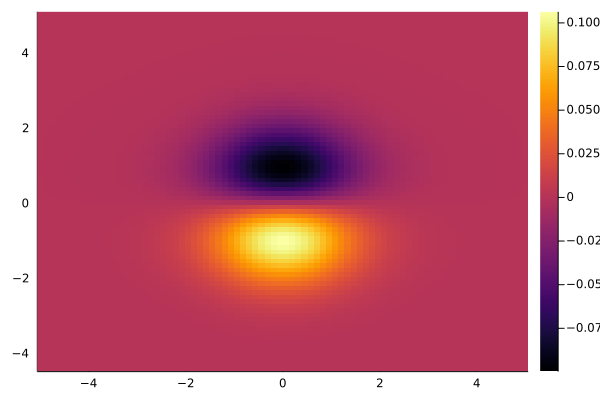

In [98]:
heatmap(rs, us, reshape(llΨ[:,1], N, N)')

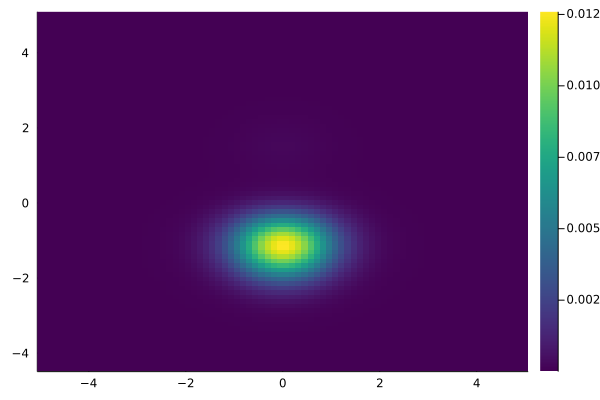

In [99]:
Ψ1 = ΨHBO + ϵ*llΨ[:,1];
Ψ2 = ΨHBO + ϵ*llΨ[:,1] + ϵ^2*llΨ[:,2];
heatmap(rs, us, reshape(Ψ2.^2, N, N)', color=:viridis)

In [116]:
norm(Ψ1 - ΨHBO), norm(Ψ2 - ΨHBO)

(0.6605906121585013, 1.0283448066990404)

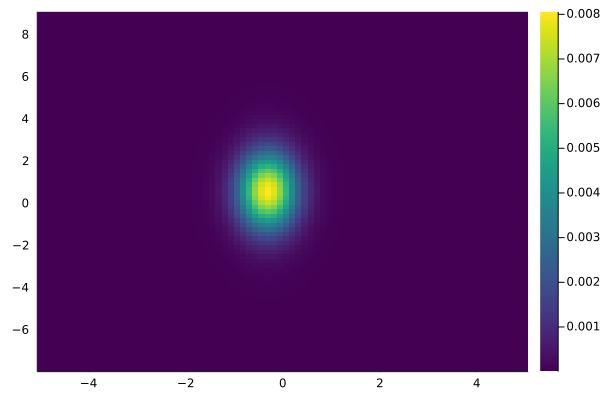

In [108]:
heatmap(rs, us, reshape(ΨHBO, N, N).^2, color=:viridis)

In [44]:
llE[:,1]

3-element Vector{Float64}:
  0.002176190508862143
 -0.0020827510654341562
  0.0008393239049772803

In [25]:
Ψ₀ = copy(ΨHBO_u);
W =  copy(Ŵ); # W: sparse
H₀ = copy(𝔥); # sparse
E₀ = EHBO;

size(ΨHBO_u), size(Ŵ), size(𝔥), typeof(ΨHBO_u), typeof(Ŵ), typeof(𝔥)


((6400,), (6400, 6400), (6400, 6400), Vector{Float64}, Diagonal{Float64, Vector{Float64}}, SparseMatrixCSC{Float64, Int64})

In [28]:
typeof(Ψ₀), typeof(W), typeof(H₀)

(Vector{Float64}, Diagonal{Float64, Vector{Float64}}, SparseMatrixCSC{Float64, Int64})

In [87]:
Ψ_sol = copy(Ψ₀);
for i in 1:Qmax
    @views Ψ_sol[:] = Ψ_sol + llΨ[:,i]
end

1000-element Vector{Float64}:
  2.2730197919207516e18
  1.6639415017272294e18
  6.046414727227094e17
  1.627485386892047e18
  4.1641958306064506e17
  6.249926236996804e17
  2.618696600683088e17
 -1.2747284455098263e18
 -1.3151038500694825e19
  2.2707525499790597e18
  ⋮
  9.560849217681838e17
  2.844698717738471e18
 -1.6503522047531715e18
  9.167782246730852e17
  1.6241362017640755e18
  3.7501072959691827e18
  2.1135775013402384e17
  4.06690649961813e17
  2.438309758169199e18